## Libraries

In [420]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Data review

In [368]:
card_data = pd.read_csv("/Users/a123456/Desktop/Projekty/Predicting_Credit_Card_Approvals/credit+approval/crx.data",header=None) 
cc_apps=card_data.copy()
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [369]:
cc_apps.describe()

,2,7,10,14
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


In [370]:
cc_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    object 
 13  13      690 non-null    object 
 14  14      690 non-null    int64  
 15  15      690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


## Cleaning data

Deletion of non-relevant data

In [371]:
cc_apps=cc_apps.drop(cc_apps.columns[[1,11,13]],axis=1)
cc_apps = cc_apps.reset_index(drop=True)

Columns names updating

In [372]:
cc_apps.columns = [str(i) for i in range(cc_apps.shape[1])] 
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,b,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,5.625,u,g,w,v,1.71,t,f,0,s,0,+


### Missing values

In [373]:
cc_apps = cc_apps.replace('?', pd.NA)

In [374]:
cc_apps.isna().sum()

0     12
1      0
2      6
3      6
4      9
5      9
6      0
7      0
8      0
9      0
10     0
11     0
12     0
dtype: int64

Maximum percentage of deleted data per column 

In [375]:
12*100/690

1.7391304347826086

Percentage of deleted data

In [376]:
(cc_apps.isna().sum().sum())*100/690

6.086956521739131

In [377]:
cc_apps.dropna(axis=0, inplace=True)

In [378]:
cc_apps.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

## Checking data

The chi-squared test assesses whether there is a significant association between two categorical variables. It helps to determine if the observed frequencies differ from the frequencies expected under the assumption of independence.
- (H0): There is no association between the variables (they are independent).
- (H1): There is an association between the variables (they are not independent).

In [379]:
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,b,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,5.625,u,g,w,v,1.71,t,f,0,s,0,+


In [380]:
def ch_2bonf(df):
    zmienne = list(df.columns)
    liczba_testow = len(zmienne) * (len(zmienne) - 1) / 2 #Liczba wszystkich możliwych par testów
    alfa_bonferroni = 0.05 / liczba_testow
    print(f"Skorygowany poziom istotności: {alfa_bonferroni}")

    for i in range(len(zmienne)):
        for j in range(i+1, len(zmienne)):
            tabela_przestawna = pd.crosstab(df[zmienne[i]], df[zmienne[j]])
            stat, p, dof, expected = chi2_contingency(tabela_przestawna)
            if p >= alfa_bonferroni:
                print(f"Nie znaleziono statystycznie istotnej zależności.")
                print(f"Test chi-kwadrat dla {zmienne[i]} vs {zmienne[j]}:")
                print(f"Statystyka={stat}, p={p}\n")

In [381]:
ch2result=ch_2bonf(cc_apps)
ch2result

Skorygowany poziom istotności: 0.000641025641025641
Nie znaleziono statystycznie istotnej zależności.
Test chi-kwadrat dla 0 vs 1:
Statystyka=203.8320078047908, p=0.6797982234230798

Nie znaleziono statystycznie istotnej zależności.
Test chi-kwadrat dla 0 vs 2:
Statystyka=3.6013420014079203, p=0.16518800975515074

Nie znaleziono statystycznie istotnej zależności.
Test chi-kwadrat dla 0 vs 3:
Statystyka=3.6013420014079203, p=0.16518800975515074

Nie znaleziono statystycznie istotnej zależności.
Test chi-kwadrat dla 0 vs 6:
Statystyka=128.2607863155258, p=0.5513802701281089

Nie znaleziono statystycznie istotnej zależności.
Test chi-kwadrat dla 0 vs 7:
Statystyka=0.17853936110796703, p=0.6726315069582038

Nie znaleziono statystycznie istotnej zależności.
Test chi-kwadrat dla 0 vs 8:
Statystyka=3.4201884325996894, p=0.06440366163285269

Nie znaleziono statystycznie istotnej zależności.
Test chi-kwadrat dla 0 vs 9:
Statystyka=22.4624209132364, p=0.4325950904193057

Nie znaleziono statystyc

- There are no grounds to reject the null hypothesis. 
- After using the chi-squared test, it’s crucial to ensure these predictors do not exhibit multicollinearity. VIF quantifies how much the variance of a regression coefficient is inflated due to collinearity with other predictors. High VIF values indicate that a predictor has a strong linear relationship with other predictors, which can affect the stability and interpretability of the regression model. Before conducting VIF it's essential to encode categorical variables.

In [382]:
#cleaned_data= cc_apps.drop(cc_apps.iloc[:,[6,9,11]],axis=1)
#cleaned_data.head()

### Encoding categorical features

The remove_rare_values function processes the data frame and modifies its columns, removing values that are rare - they occur with a frequency of less than 5%.

In [383]:
def remove_rare_values(data):
    data = data.copy()
    for col in data.columns:
        if col != data.columns[1] and data[col].dtype == 'object':
            value_counts = data[col].value_counts(normalize=True) * 100
            rare_values = value_counts[value_counts < 5].index
            data = data[~data[col].isin(rare_values)].dropna()
    return data

In [384]:
def unique_val(data):
    for i in range(len(data.columns)):
        if data.dtypes[i] == 'object':
            column_name = data.columns[i] 
            unikalne_wartosci = data.iloc[:, i].unique()
            num_unik = len(unikalne_wartosci)
            zliczenie = data.iloc[:, i].value_counts()
            print(f"Unikalne wartości {num_unik} z kolumny {column_name}: {unikalne_wartosci},\nZliczone wartosci z kolumny {column_name}:\n{zliczenie}")


Before removing

In [385]:
unique_val(cc_apps)

Unikalne wartości 2 z kolumny 0: ['b' 'a'],
Zliczone wartosci z kolumny 0:
0
b    463
a    208
Name: count, dtype: int64
Unikalne wartości 3 z kolumny 2: ['u' 'y' 'l'],
Zliczone wartosci z kolumny 2:
2
u    510
y    159
l      2
Name: count, dtype: int64
Unikalne wartości 3 z kolumny 3: ['g' 'p' 'gg'],
Zliczone wartosci z kolumny 3:
3
g     510
p     159
gg      2
Name: count, dtype: int64
Unikalne wartości 14 z kolumny 4: ['w' 'q' 'm' 'r' 'cc' 'k' 'c' 'd' 'x' 'i' 'e' 'aa' 'ff' 'j'],
Zliczone wartosci z kolumny 4:
4
c     135
q      76
w      63
i      58
aa     53
ff     53
k      50
cc     40
m      38
x      38
d      30
e      24
j      10
r       3
Name: count, dtype: int64
Unikalne wartości 9 z kolumny 5: ['v' 'h' 'bb' 'ff' 'j' 'z' 'o' 'dd' 'n'],
Zliczone wartosci z kolumny 5:
5
v     392
h     137
bb     57
ff     57
j       8
z       8
dd      6
n       4
o       2
Name: count, dtype: int64
Unikalne wartości 2 z kolumny 7: ['t' 'f'],
Zliczone wartosci z kolumny 7:
7
t    358
f 

After removing

In [386]:
cc_apps=remove_rare_values(cc_apps)
unique_val(cc_apps)

Unikalne wartości 2 z kolumny 0: ['b' 'a'],
Zliczone wartosci z kolumny 0:
0
b    411
a    186
Name: count, dtype: int64
Unikalne wartości 2 z kolumny 2: ['u' 'y'],
Zliczone wartosci z kolumny 2:
2
u    456
y    141
Name: count, dtype: int64
Unikalne wartości 2 z kolumny 3: ['g' 'p'],
Zliczone wartosci z kolumny 3:
3
g    456
p    141
Name: count, dtype: int64
Unikalne wartości 10 z kolumny 4: ['w' 'q' 'm' 'cc' 'k' 'c' 'x' 'i' 'aa' 'ff'],
Zliczone wartosci z kolumny 4:
4
c     132
q      75
w      63
i      57
aa     53
ff     52
k      50
cc     39
m      38
x      38
Name: count, dtype: int64
Unikalne wartości 4 z kolumny 5: ['v' 'h' 'bb' 'ff'],
Zliczone wartosci z kolumny 5:
5
v     363
h     127
ff     54
bb     53
Name: count, dtype: int64
Unikalne wartości 2 z kolumny 7: ['t' 'f'],
Zliczone wartosci z kolumny 7:
7
t    327
f    270
Name: count, dtype: int64
Unikalne wartości 2 z kolumny 8: ['t' 'f'],
Zliczone wartosci z kolumny 8:
8
f    326
t    271
Name: count, dtype: int64
Uni

In [387]:
def transfor_cat(data, original_columns):
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(data)
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(original_columns))
    return encoded_df

In [388]:
def wspol_VIF(data):
    data1=data.copy()
    data1 = add_constant(data1)
    VIF_data = pd.DataFrame()
    VIF_data['feature'] = data1.columns
    VIF_data['VIF'] = [variance_inflation_factor(data1.values, i) for i in range(data1.shape[1])]
    return VIF_data

In [389]:
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,b,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,5.625,u,g,w,v,1.71,t,f,0,s,0,+


In [390]:
columns_to_transform = [0, 2, 3, 4, 5, 7, 8, 10]
data_to_transform = cc_apps.iloc[:, columns_to_transform]
original_columns = cc_apps.columns[columns_to_transform]
raw_data = transfor_cat(data_to_transform, original_columns)

In [391]:
raw_data.to_excel('grab.xlsx')

In [392]:
wspol_VIF(raw_data)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/homebrew/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,0.0
1,0_a,inf
2,0_b,inf
3,2_u,inf
4,2_y,inf
5,3_g,inf
6,3_p,inf
7,4_aa,inf
8,4_c,inf
9,4_cc,inf


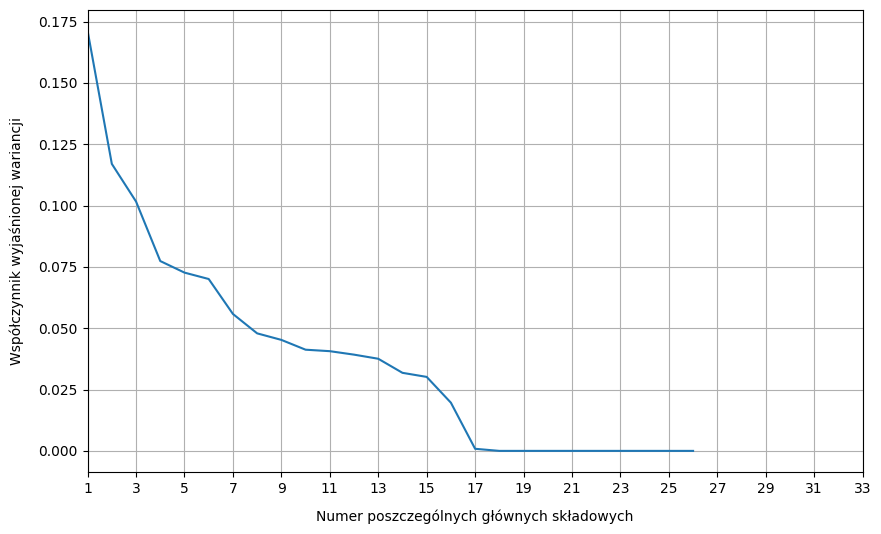

In [394]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer',PCA())])
after_pca=pipe.fit(raw_data) 
var= pipe['reducer'].explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(var)+1),var)
plt.xlabel('Numer poszczególnych głównych składowych',labelpad=10)
plt.ylabel('Współczynnik wyjaśnionej wariancji',labelpad=10)
plt.xlim(left=1)
plt.xticks(np.arange(1,34,2))
plt.grid(True)
plt.show()

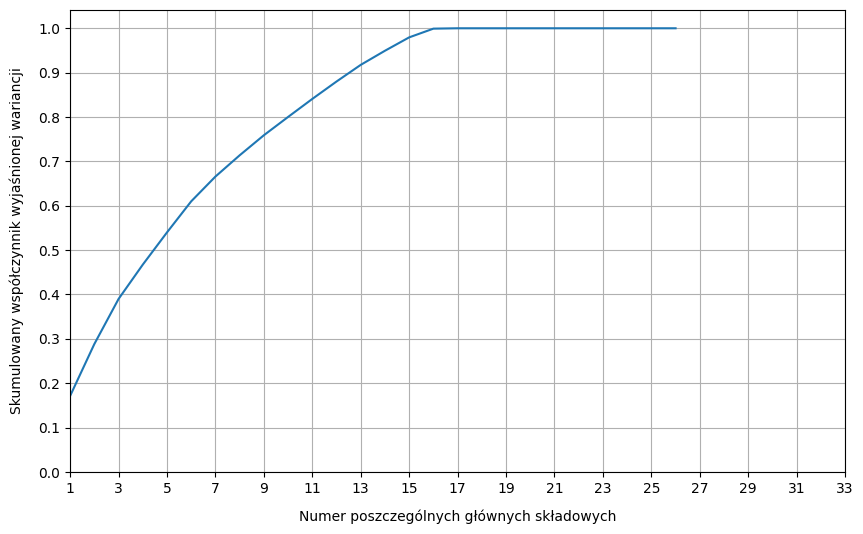

In [395]:
cumulative_var = np.cumsum(var)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_var)+1), cumulative_var)
plt.xlabel('Numer poszczególnych głównych składowych',labelpad=10)
plt.ylabel('Skumulowany współczynnik wyjaśnionej wariancji',labelpad=10)
plt.xlim(left=1)
plt.xticks(np.arange(1,34,2))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True)
plt.show()

In [396]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer',PCA(n_components=8))]) 
pca_ready=pipe.fit_transform(raw_data)

In [397]:
pca_df = pd.DataFrame(pca_ready, columns=[f'PC{i+1}' for i in range(8)])
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-1.797291,-0.621205,-1.517045,-0.430403,-1.736869,0.833606,0.561766,-0.983915
1,-2.700255,-2.231360,1.204899,-0.132517,2.306261,-0.262643,-0.524536,0.335704
2,-1.793692,-0.854128,1.376344,-0.106774,2.777146,-1.165169,-1.419622,-0.280870
3,-1.797291,-0.621205,-1.517045,-0.430403,-1.736869,0.833606,0.561766,-0.983915
4,-0.477420,3.238294,-2.199192,-0.191994,1.645241,2.884098,0.148576,-1.253831


In [398]:
wspol_VIF(pca_df)

,feature,VIF
0,const,1.0
1,PC1,1.0
2,PC2,1.0
3,PC3,1.0
4,PC4,1.0
5,PC5,1.0
6,PC6,1.0
7,PC7,1.0
8,PC8,1.0


The Shapiro-Wilk test is a statistical test used to assess the normality of a data sample. 
- (H0): The data is normally distributed.
- (H1): The data is not normally distributed.

In [421]:
def distribution_test(data):
    for column in data.columns:
        stat, p = stats.shapiro(data[column])
        print(f'Shapiro-Wilk test dla {column}: stat={stat}, p={p}')
        if p > 0.05:
            print(f'Column:{column}, there are no grounds to reject H0\n')
        else:
            print(f'Column:{column}, rejection of H0')

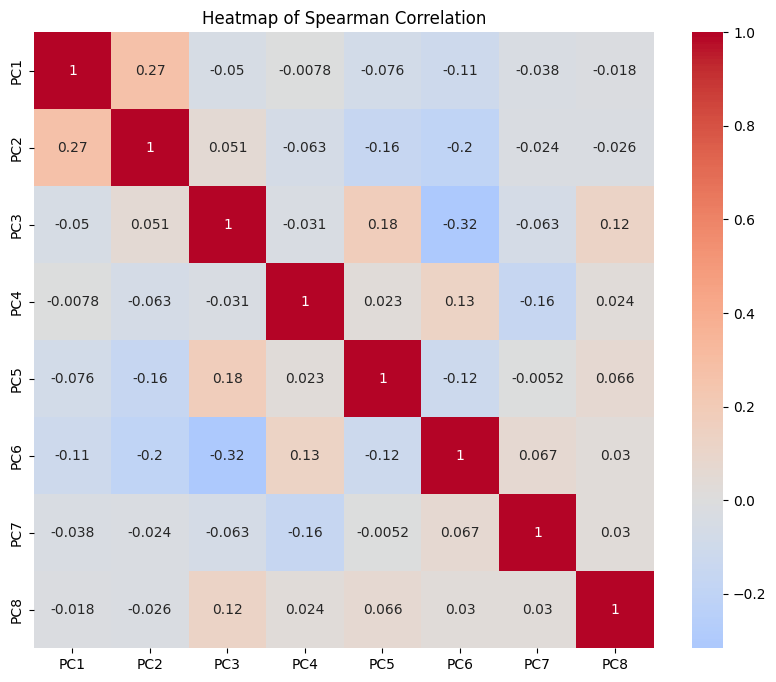

In [418]:
spearman_corr_matrix = pca_df.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Spearman Correlation')
plt.show()

## Model

Model with raw data

In [399]:
y_dt=cc_apps.iloc[:,12]
X_trainr, X_testr, y_trainr, y_testr = train_test_split(pca_df,y_dt,test_size=0.3,random_state=123)
default_lr_params = {
        'C': 1.0,
        'max_iter': 100,
        'solver': 'lbfgs',
        'penalty': 'l2',
        'tol': 1e-4}

In [400]:
def init_model(X_train, X_test, y_train, y_test,lr_params=None):
       if lr_params is None:
              lr_params = {}
       steps=[("minmaxscaler",MinMaxScaler()),
              ("logisticregression",LogisticRegression(**lr_params))]
       pipeline=Pipeline(steps)
       pipeline.fit(X_train,y_train)
       score_tr=round(pipeline.score(X_train,y_train),3)
       pred_y=pipeline.predict(X_test)
       prawd=pipeline.predict_proba(X_test)
       score_ts=round(pipeline.score(X_test,y_test),3)
       conf=confusion_matrix(y_test,pred_y)
       print(f"Training Score is equal: {score_tr}\nTesting Score is equal: {score_ts}\n Confusion matrix\n {conf}")
       return pred_y, prawd, pipeline

In [401]:
predictionr, probabr, pipeliner = init_model(X_trainr, X_testr, y_trainr, y_testr,default_lr_params)

Training Score is equal: 0.875
Testing Score is equal: 0.85
 Confusion matrix
 [[69 14]
 [13 84]]


In [402]:
def tunning(X_train,y_train,pipeline,penalty,C,tol,iter,solv):
    kf=KFold(n_splits=10,random_state=123,shuffle=True)
    param_grid = {
        "logisticregression__penalty": penalty,
        "logisticregression__C": C,
        "logisticregression__tol": tol,
        "logisticregression__max_iter": iter,
        "logisticregression__solver":solv
    }

    model=GridSearchCV(pipeline,param_grid,cv=kf)
    model.fit(X_train,y_train)
    print(f"Best cross-validation score: {round(model.best_score_, 3)}")
    return (model.best_params_)

In [403]:
def dict_for_init_model(after_tunning):
    cleaned_params = {}
    for key, value in after_tunning.items():
        if '__' in key:
            new_key = key.split('__', 1)[1]
            cleaned_params[new_key] = value
        else:
            cleaned_params[key] = value
    return cleaned_params

Checking solvers:"lbfgs","newton-cg" for raw model

In [404]:
tunning(X_trainr,y_trainr,pipeliner,["l2"],[0.001, 0.01, 0.1, 1, 10],[0.01, 0.001, 0.0001],np.arange(100,200,50),["lbfgs","newton-cg"])

Best cross-validation score: 0.866


{'logisticregression__C': 10,
 'logisticregression__max_iter': 100,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.01}

In [405]:
tun_lbfgs=tunning(X_trainr,y_trainr,pipeliner,["l2"],np.arange(10,11,0.1),np.arange(0,0.1,0.01),np.arange(50,100,50),['lbfgs'])
tun_lbfgs

Best cross-validation score: 0.866


{'logisticregression__C': 10.0,
 'logisticregression__max_iter': 50,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0}

In [406]:
tun_lbfgs=dict_for_init_model(tun_lbfgs)
predictionlb, probablb, pipelinelb = init_model(X_trainr, X_testr, y_trainr, y_testr,lr_params=tun_lbfgs)

Training Score is equal: 0.871
Testing Score is equal: 0.844
 Confusion matrix
 [[68 15]
 [13 84]]


Checking solvers: "liblinear","saga" for raw model

In [407]:
tun_saga=tunning(X_trainr,y_trainr,pipeliner,["l1","l2"],np.arange(0.1,1.2,0.1),np.arange(0.01,0.1,0.01),np.arange(400,700,20),["liblinear","saga"])
tun_saga

Best cross-validation score: 0.883


{'logisticregression__C': 1.1,
 'logisticregression__max_iter': 420,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'saga',
 'logisticregression__tol': 0.09}

In [408]:
tun_saga=dict_for_init_model(tun_saga)
predictionlb, probablb, pipelinelb = init_model(X_trainr, X_testr, y_trainr, y_testr,lr_params=tun_saga)

Training Score is equal: 0.871
Testing Score is equal: 0.856
 Confusion matrix
 [[70 13]
 [13 84]]
